# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1:compute the camera calibration using chessboard images and undistorted the image.
---

In [1]:
#cell No.1
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
#images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
#for fname in images:
    
image_files = os.listdir("../camera_cal/")

for file in image_files:
    set_filename = "../output_images/"+'done'+file

    image_file = os.path.join("../camera_cal/", file)
    
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        dst = cv2.undistort(img, mtx, dist, None, mtx)# this is the undistorted image
        
        #cv2.imshow('img',img)
        
        #cv2.imshow('dst',dst)
        #cv2.imwrite(set_filename,dst)
        #cv2.waitKey(200)

#cv2.destroyAllWindows()

## 2:Use color transforms, gradients, etc., to create a thresholded binary image.

grayscale threshold

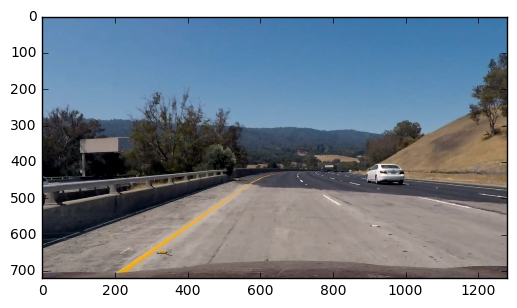

In [30]:
#cell no.2
img = cv2.imread("../test_images/t.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.undistort(img, mtx, dist, None, mtx)#undistort the image
cv2.imwrite("../output_images/test1_undistorted.jpg",cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


plt.imshow(img);


HSL threshold

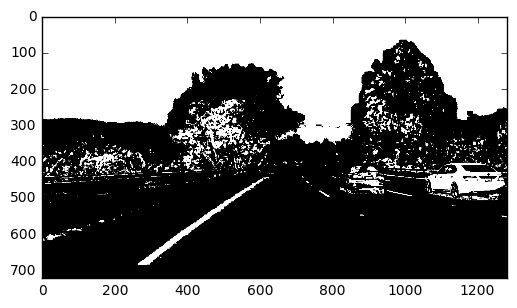

In [40]:
#cell no.3
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh = (200, 255)
HSLt = np.zeros_like(S)
HSLt[(L > thresh[0]) & (L <= thresh[1])] = 1

thresh = (100, 255)
HSLt2 = np.zeros_like(S)
HSLt2[(S > thresh[0]) & (S <= thresh[1])] = 1

HSLA = np.zeros_like(S)
HSLA[(HSLt == 1) | (HSLt2 == 1)]=1
plt.imshow(HSLA,'gray')


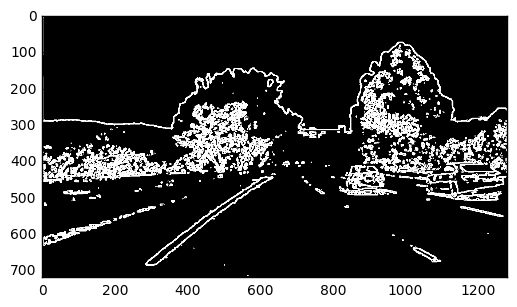

In [18]:
#cell no.4
sobelx = cv2.Sobel(HSLt, cv2.CV_64F, 1, 0, ksize=7)
sobely = cv2.Sobel(HSLt, cv2.CV_64F, 0, 1, ksize=7)
# Calculate the gradient magnitude
gradmag = np.sqrt(sobelx**2 + sobely**2)
#gradmag = sobelx
# Rescale to 8 bit
scale_factor = np.max(gradmag)/255 
gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
# Threshold x gradient
thresh_min = 30
thresh_max = 255
sxbinary = np.zeros_like(gradmag)
sxbinary[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

plt.imshow(sxbinary,'gray')

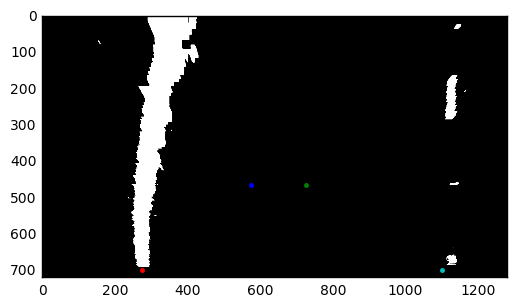

In [19]:
#cell no.5
plt.imshow(img)
plt.plot(574,464,'.')
plt.plot(725,464,'.')
plt.plot(275,700,'.')
plt.plot(1100,700,'.')

img_size=(img.shape[1],img.shape[0])

src=np.float32([[574,464],[725,464],[275,700],[1100,700]])
dst=np.float32([[275,0],[1100,0],[275,700],[1100,700]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

binary_warped = cv2.warpPerspective(HSLt, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped,'gray')

C:\Users\HYF\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


(720, 0)

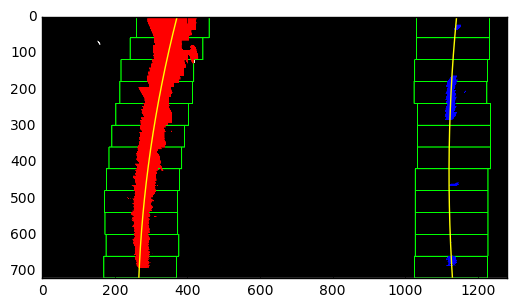

In [20]:
#cell no.6
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 12
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

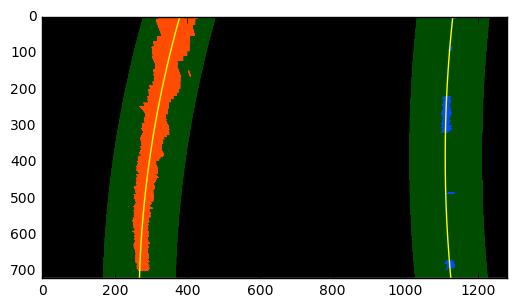

In [27]:
#cell no.7
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [28]:
#cell no.8
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

2858.86152808 3630.07906901


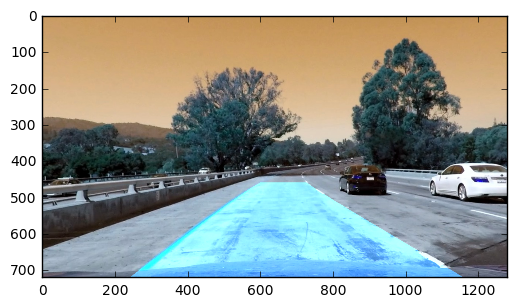

In [29]:
#cell no.9
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,130, 255))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)#...no idea why opencv use bgr
result = cv2.addWeighted(img, 1, newwarp, 0.6, 0)

plt.imshow(result)

C:\Users\HYF\Anaconda3\lib\site-packages\skimage\filter\__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
C:\Users\HYF\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


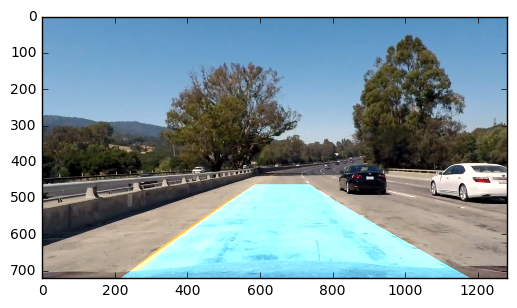

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import copy

righty_bef = []


def process_image(img):
    global righty_bef
    img = cv2.undistort(img, mtx, dist, None, mtx)#undistort the image
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    thresh = (200, 255)
    HSLt = np.zeros_like(S)
    HSLt[(L > thresh[0]) & (L <= thresh[1])] = 1

    thresh = (100, 255)
    HSLt2 = np.zeros_like(S)
    HSLt2[(S > thresh[0]) & (S <= thresh[1])] = 1

    HSLA = np.zeros_like(S)
    HSLA[(HSLt == 1) | (HSLt2 == 1)]=1
    
    #cell no.4
    sobelx = cv2.Sobel(HSLA, cv2.CV_64F, 1, 0, ksize=7)
    sobely = cv2.Sobel(HSLA, cv2.CV_64F, 0, 1, ksize=7)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    #gradmag = sobelx
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    # Threshold x gradient
    thresh_min = 30
    thresh_max = 255
    sxbinary = np.zeros_like(gradmag)
    sxbinary[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    img_size=(img.shape[1],img.shape[0])

    src=np.float32([[574,464],[725,464],[275,700],[1100,700]])
    dst=np.float32([[275,0],[1100,0],[275,700],[1100,700]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    binary_warped = cv2.warpPerspective(sxbinary, M, img_size, flags=cv2.INTER_LINEAR)

    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix =50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
     
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)   
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    
    
    righty = nonzeroy[right_lane_inds] 
    
    if len(righty)==0:
        #righty = copy.deepcopy(righty_bef)
        return img
    else:
        righty_bef = copy.deepcopy(righty)
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,190, 255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)#...no idea why opencv use bgr
    result = cv2.addWeighted(img, 1, newwarp, 0.6, 0)
    
    
    return result

img = cv2.imread("../test_images/v.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)#...no idea why opencv use bgr
plt.imshow(process_image(img))

In [3]:
white_output = 'project_video_process.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)


MoviePy: building video file project_video_process.mp4
----------------------------------------

Writing video into project_video_process.mp4
|----------| 0/1210   0% [elapsed: 00:00 left: ?, ? iters/sec]

C:\Users\HYF\Anaconda3\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
C:\Users\HYF\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Done writing video in project_video_process.mp4 !
Your video is ready !
